### Counting number of cells - Computer Vision 2023

This code is used to count the number of cells of a video of cells in microdroplets. Then using background subtraction algorithms and other algorithms to count the cells in each droplet.

Notes for use:
Video should be provided in .tif format
The ouput gives an image of the background/foreground mask as well as the count of cells in each droplet.

Created by Turlagh Clancy - 18/10/2023

Update log:

In [1]:
# Base code
#1. Upload the tif file - done
#2. do background subtraction algorithm (as a function) - done
#3. Visualise background subtraction algorithm  - done

#Improvements
#4. Find better background frame to initialise - done
#5. find better way to update background 
#6. Find a better background subtraction method, compare computation times, discuss quantitative assesments

#Later part 2.2
#7. import cell counts and boxes - 
#8. use algorithm to count cells in each box - have multiple methods
#9. Work on other counting methods, and compare them

In [17]:
#import libraries

import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os

import matplotlib.animation as mat_anim
from IPython.display import HTML
from sklearn.linear_model import LinearRegression

In [2]:
# Function to present the Original and BGS frames side by side for visualisation. Created by Benoit Lu and given permission to use here on 18/10/2023
def draw_frames(frames, bgs_frames):
    if len(frames) != len(bgs_frames):
        raise Exception("The number of frames on each array doesn't match.")
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    plt.tight_layout()

    def update(frame):
        plt.suptitle(f"Frame {frame}")
        axs[0].clear() 
        axs[1].clear()  
        axs[0].set_title("Original")
        axs[0].imshow(frames[frame], cmap='gray')  
        axs[1].set_title("BGS")
        axs[1].imshow(bgs_frames[frame], cmap='gray') 
        return axs

    return mat_anim.FuncAnimation(fig=fig, func=update, frames=len(frames), interval=500)

def convert_to_grayscale(rgb_image):
    return np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])

def process_TIF(filepath): # Function to get from tif file to grayscale image, maybe should change imread to only get grayscale
    #tif file to RGB numpy array
    array = tiff.imread(filepath)
    #convert to greyscale
    gray_arr = convert_to_grayscale(array)
    return gray_arr

def picture_frames(frame_list, frame_index):
    # Create a single image with all frames displayed side by side
    # frame_list is a list of frames you want to display

    num_frames = len(frame_list)

    fig, axs = plt.subplots(1, num_frames, figsize=(4 * num_frames, 4))
    plt.tight_layout()

    for i in range(num_frames):
        ax = axs[i]
        frame = frame_list[i]
        frame_name = frame_index[i]
        title = f"Frame {frame_name}"
        ax.imshow(frame, cmap='gray')
        ax.set_title(title)
        ax.axis('off')  # Hide the axis

    plt.show()


def crop_frame(frame, target_height):
    return frame[:target_height, :]

def CreateBaseBackgroundImage(folderpath, outputfile = 'output.tif'):
    tif_files = [file for file in os.listdir(folderpath) if file.endswith(".tif")]

    first_file = os.path.join(folderpath, tif_files[0])
    background = crop_frame(tiff.imread(first_file)[0], target_height=1100)

    total_frames = 1

    for tif_file in tif_files:
        file_path = os.path.join(folderpath, tif_file)
        frames = tiff.imread(file_path)
        frames = np.array([crop_frame(frame, target_height=1100) for frame in frames])
        background = (background * total_frames + np.sum(frames, axis=0)) / (total_frames + len(frames))
        total_frames += len(frames)

    backgroundImageGrey = convert_to_grayscale(background).astype(np.uint8)
    tiff.imsave(outputfile, backgroundImageGrey)

    return backgroundImageGrey

In [5]:
def simple_background_subtraction(frames, threshold=30, init_learning_rate=0.30, background_init=None):
    # Function to apply our background subtraction algorithm
    #   frames is a numpy array with dimensions (num_frames, width, height)
    #   threshold is a parameter that determines how close or far the pixel values have to differ from the background to be considered foreground
    #   learning_rate_scheduler is a function that returns the learning rate based on the frame number
    #   Background Init should be a numpy array of the background frame
    
    # Initialize array for the foreground
    num_frames, width, height = frames.shape
    grayscale_masks = np.zeros((num_frames, width, height), dtype=np.uint8)

    # Either choose the initialize background path or replace it with the average value of the frame
    if background_init is not None:
        if background_init.shape == (width, height):
            background_frame = background_init
        else:
            raise ValueError("The dimensions of the external background image do not match the input frames.")
    else:
        background_frame = frames[0]

    # Loop through each frame and compare it to the background frame
    for frame_num in range(0, num_frames):
        current_frame = frames[frame_num]

        # Calculate the difference between frame and background
        frame_diff = np.abs(current_frame - background_frame)
        grayscale_mask = (frame_diff > threshold).astype(np.uint8) * 255

        # Calculate the current learning rate using the scheduler
        if init_learning_rate is not None:
            current_learning_rate = init_learning_rate
        else:
            current_learning_rate = 0.05  # Default learning rate if no scheduler is provided

        # Update the background frame with the current learning rate
        background_frame = background_frame * (1 - current_learning_rate/(frame_num+1)) + current_frame * current_learning_rate/(frame_num +1)

        # Store the inverted grayscale mask in the result (foreground is black, background is white)
        grayscale_masks[frame_num] = grayscale_mask

    return grayscale_masks

In [23]:
class background_subtraction_v2():
    def __init__(self, frames, params):
        self.frames = frames

        self.alpha = params[0]                  # exponential filter

        self.threshold = params[1]              # threshold comparison

        self.nbIinit = params[2]                # number of frames to wait for the bg init

        self.initFrameId = params[2]-1           # id of the first frame

        self.methodUpdate = params[3]           # 0  if alpha is constnat, 1 for decreasing alpha

        self.nbFrames = 0                       # number of frames for the decreasing alpha

        self.binMaps = []                       # list of binary maps

        self.initVersion = params[4]            # 0: model, 1: median
        
    def _initBg(self, frames: list)->np.array:
        """ 
        Initialization of the algorithm

        Args:
        -----
        - `frames`: list of frames from which the init background is obtained
        """
        
        if self.initVersion == 0:
            bg = initialBackgroundv2(frames[0])     
        elif self.initVersion == 1:
            bg = medianInit(frames[:self.nbIinit])

        return bg

    def _updateBg(self, prevBg:np.array, frame:np.array, alpha:float, bMap:np.array)->np.array:
        """ 
        Function to perform the update

        Args:
        -----
        -`prevBg`: previous background
        - `frame`: current frame
        - `alpha`: learning rate
        - `bMap`: binary map from background subtraction (not used)
        """
        return ((1-alpha) * prevBg + alpha * frame)

    
    def _compareFrames(self, frame:np.array, bg:np.array, threshold:float)->np.array:
        """  
        Function to compare the background and the foreground

        Args:
        -----
        - `frame`: foreground
        - `bg`: background
        - `threshold`: threshold in the comparison

        Returns:
        --------
        The binary map
        """

        d = np.abs(bg - frame)

        bMap = (d >= threshold)
        return bMap


    def _loop(self):
        """ 
        Main function to apply the background subtraction algorithm
        """

        ## initialize the background
        bg = self._initBg(self.frames)

        for i in range(self.initFrameId, len(self.frames)):

            ## compare background and foreground
            bMap = self._compareFrames(self.frames[i], bg, self.threshold)
            
            self.binMaps.append(bMap)

            ## get the current alpha
            if self.methodUpdate:
                alpha = self.alpha / (self.nbFrames+1)
                self.nbFrames += 1
            else:
                alpha = self.alpha

            # update the background
            bg = self._updateBg(bg, self.frames[i], self.alpha, bMap)

            bg = bg.astype(int)
        return self.binMaps
    
def initialBackgroundv2(frame: np.array, thresh1:float = 2., nbLine:int = 5)->np.array:
    """ 
    Creates the model of the background

    Args:
    -----
    - `frame`: the one frame we want to create the background from
    - `thresh1`: value of the threshold on the heuristic for the detection
                 of black bands
    - `nbLine`: number of randomly selected lines for the linear model

    Output:
    -------
    The background of the image
    """
    
    L = frame.shape[0] // 2     # take the mid of the height
    
    ## detect big lines and zone above or below black bands
    #  (will simply set them as the background --> big assumption here)

    # since the black bands are horizontal, performing a sum over the width
    # should give some values that are significantly smaller than the rest 
    # then, we just have to detect those important low values

    test = np.sum(frame, axis = 1)          
    thresh = np.min(test) * thresh1
    ids = np.where(test < thresh)[0]        # y ids of the lines

    idMin = ids[ids < L]
    idMax = ids[ids > L]
    maxIdMin = np.max(idMin)
    minIdMax = np.min(idMax)

    idMin = np.arange(maxIdMin+1)
    idMax = np.arange(minIdMax, frame.shape[0])

    ## tackle the middle part
    ## model the horizontal color shift
    linearIdsList = np.random.randint(0, frame.shape[0], nbLine)

    y = None

    for i in range(len(linearIdsList)):
        if linearIdsList[i] in idMin or linearIdsList[i] in idMax:
            if linearIdsList[i] < L:
                linearIdsList[i] += np.random.randint(40, L)    #just to get it off the black bands zone
            else:
                linearIdsList[i] -= np.random.randint(40, L)    # just to get it off the black bands zone
        
        if y is None:
            y = frame[i, :].reshape(1, -1)
        else:
            y = np.vstack((y, frame[i, :]))

    X = np.tile(np.arange(frame.shape[1])[np.newaxis, :], (len(linearIdsList), 1))


    model = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))
    preds = model.predict(np.arange(frame.shape[1]).reshape(-1,1)).reshape(1,-1)
    bg = np.tile(preds, (frame.shape[0], 1))
    
    # replace the two black bands zones with the values from the frame

    bg[idMin, :] = frame[idMin, :]
    bg[idMax, :] = frame[idMax, :]
    bg = bg.astype(int)

    return bg

def medianInit(frames:np.array)->np.array:
    """ 
    Function to initialize the background from the first frames

    Args:
    -----
    - `frames`: starting frames
    """
    bg = None

    for f in frames:
        if bg is None:
            bg = f.reshape(1, *f.shape)

        else:
            bg = np.vstack((bg, f.reshape(1, *f.shape)))

    return np.median(bg, axis=0).astype(int)

In [6]:
# Load data - takes roughly 50sec
seq41 = process_TIF("../Data/All_Sequences/4-2.tif")
seq41 = seq41[:50]

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Background initalisation: Local background file exists, will load it


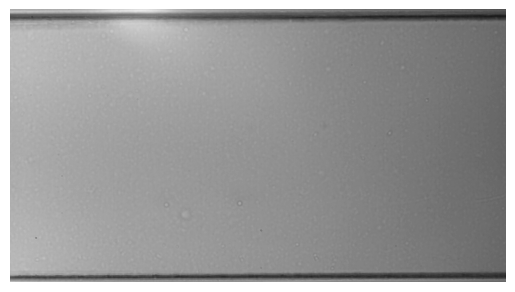

In [7]:
# show the prior background
input_folder = r"..\Data\All Sequences"
output_file = r"background_init.tif"

if os.path.exists(output_file):
    backgroundImage = convert_to_grayscale(tiff.imread(output_file))
    print("Background initalisation: Local background file exists, will load it")
else: 
    backgroundImage = CreateBaseBackgroundImage(input_folder, output_file)
    print("Background initalisation: Background file does not exist, will generate it")

plt.imshow(backgroundImage, cmap='gray', vmin=0, vmax=255)
plt.axis('off') 
plt.show()

In [8]:
%%time
#perform background subtraction and time it
bgs41 = simple_background_subtraction(seq41, threshold = 60 , init_learning_rate= 0.3, background_init= backgroundImage)

CPU times: total: 1.88 s
Wall time: 4.66 s


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


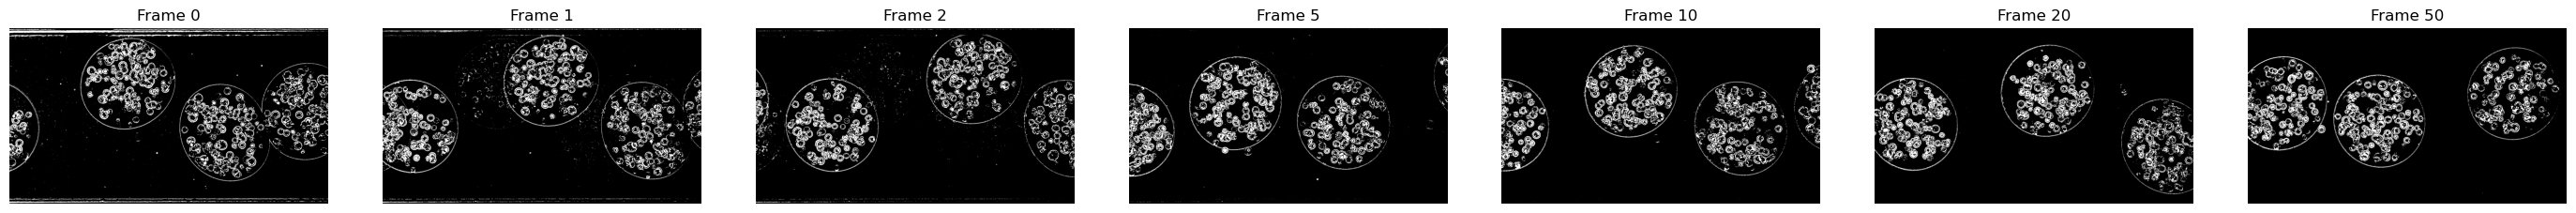

In [11]:
#picture frames side by side on different sequence
seq42 = process_TIF("../Data/All_Sequences/4-2.tif")
frames= simple_background_subtraction(seq42, threshold = 60 , init_learning_rate= 0.3, background_init= backgroundImage)
frames_index = [0,1,2,5,10,20,50]
frame_list = [frames[i] for i in frames_index]
picture_frames(frame_list, frame_index = frames_index)

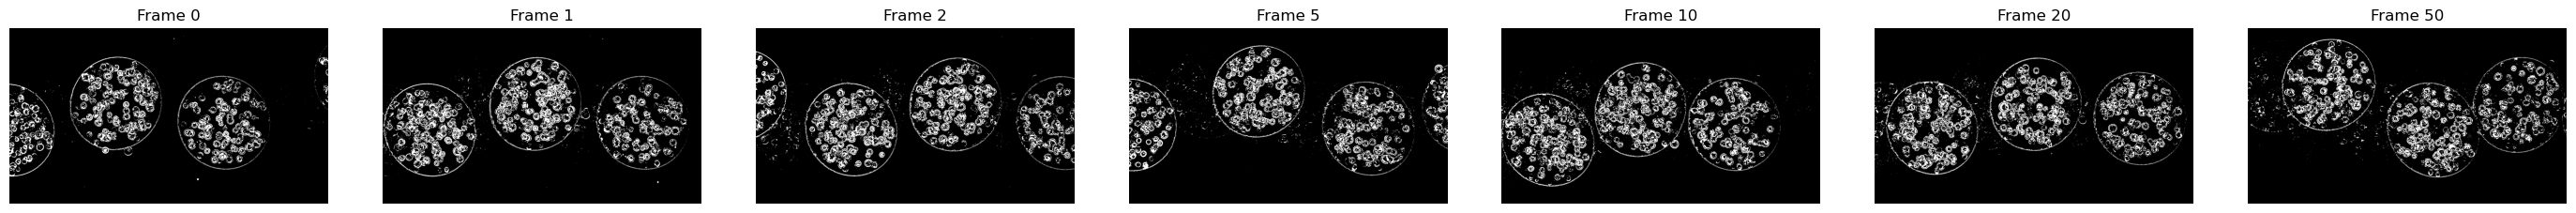

In [32]:
# Do the second version of the background subtraction algorithm and compare to the first
bgS = background_subtraction_v2(seq42, [0.30, 60, 6, 1, 1])
bMap = bgS._loop()

frame_list_2 = [bMap[i] for i in frames_index]
picture_frames(frame_list_2, frame_index = frames_index)

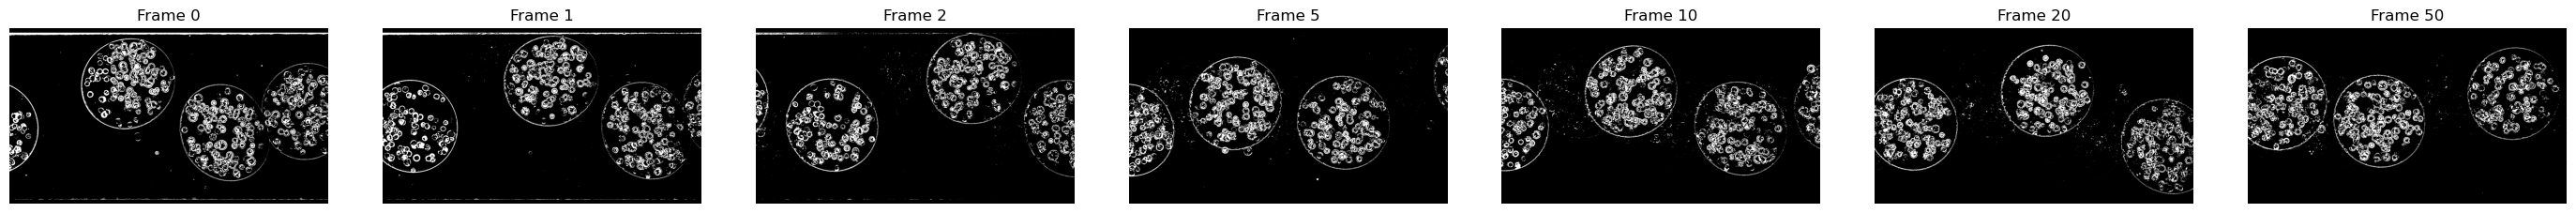

In [31]:
# Do the second version of the background subtraction algorithm and compare to the first
bgS = background_subtraction_v2(seq42, [0.30, 60, 1, 1, 0])
bMap = bgS._loop()

frames_index = [0,1,2,5,10,20,50]

frame_list_2 = [bMap[i] for i in frames_index]
picture_frames(frame_list_2, frame_index = frames_index)

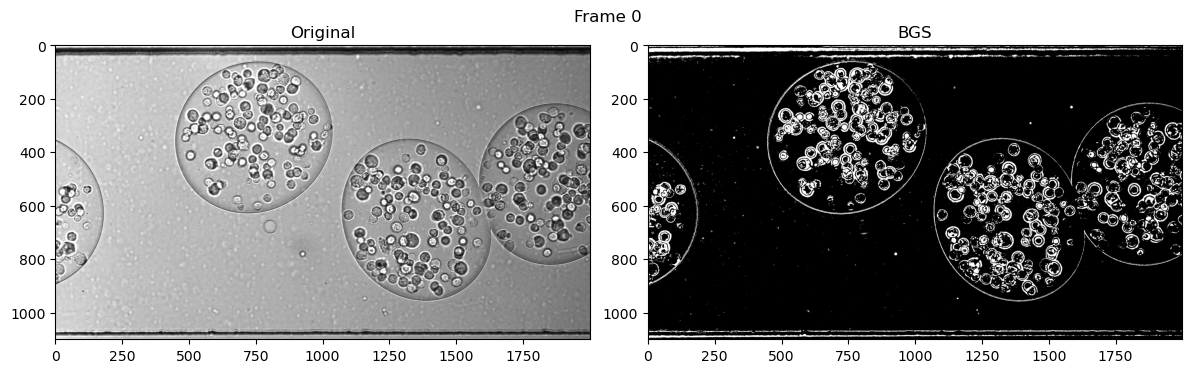

In [21]:
# Display the original side by side with the foreground masks as a video
animation = draw_frames(seq41[:20], bgs41[:20])
HTML(animation.to_html5_video())